## Multiunit recordings from several cortical areas

We will collect neurons from several cortical areas to perform population *dynamical* and *attractor* analysis, and get the *functional connectivity*.     
This will address three relevant points:
- Does the dynamic analysis hold at **higher temporal resolution**?
    - How do events statistics (duration and size) compare to 2-photon?
- Are population events only a **side-effect of behavior** (locomotion, whisker pad, pupil)?
    - Do behavioral components explain pattern reproducibility?
- Do **all areas of cortex** show attractor dynamics?
    - How do pattern trajectories compare to MICrONS?

To do all this, we analyse the [data](https://janelia.figshare.com/articles/dataset/Eight-probe_Neuropixels_recordings_during_spontaneous_behaviors/7739750/4) by [Stringer et al. 2019](science.org/doi/10.1126/science.aav7893).   
Eight-probe Neuropixels recordings in three mice during spontaneous activity.   

This notebook calls `dynamical_analysis.ipynb` and `attractor_analysis.ipynb`.

In [7]:
from platform import python_version
print(python_version())

%run -i 'imports_functions.py' 

%matplotlib inline

3.10.4


**WARNING**: the next cell takes time to download and unzip the neuropixel data.

In [8]:
if not os.path.exists("stringer/7739750.zip"):
    print("Downloading neuropixel data ...")
    if not os.path.exists("stringer"):
        os.makedirs("stringer")
    resp = wget.download("https://janelia.figshare.com/ndownloader/articles/7739750/versions/4", "stringer/7739750.zip")
    print("... Done: "+resp)

if not os.path.exists("stringer/7739750"):
    # unzip downloaded folder
    if os.path.exists("stringer/7739750.zip"):
        print("... unzipping")
        shutil.unpack_archive("stringer/7739750.zip", "stringer/7739750")
        shutil.unpack_archive("stringer/7739750/spks.zip", "stringer/7739750/spks")
        shutil.unpack_archive("stringer/7739750/faces.zip", "stringer/7739750/faces")
    print("Done.")
else:
    print("All data available.")

All data available.


### Data preprocessing

This analysis is based on the file `ephysLoad.m`.

Each "spks" is a structure of length 8, where each entry is a different probe (these probes were recorded simultaneously). It contains the spike times (in seconds, e.g. 4048.44929626 sec (?kHz sampling)), the cluster identity of each spike (its cell), and the height of each cluster on the probe.

The location of each site on the probe in microns in the Allen CCF framework is given in "ccfCoords". The brain area for each site is in "borders" as a function of the height of the site. 

We need the spikes from each area and probe to be separate lists. So, we build a dictionary to hold them, and save it locally as `area_spiketrains.npy`.

In [9]:
if os.path.exists("stringer/7739750/area_spiketrains.npy"):
    area_spiketrains = np.load("stringer/7739750/area_spiketrains.npy", allow_pickle=True).item()
    print("... loaded populations")
else:
    print("... collecting populations")
    
    probeLoc = sio.loadmat('stringer/7739750/probeLocations.mat')
    probeBorders = sio.loadmat('stringer/7739750/probeBorders.mat', squeeze_me=True)

    mouse_names = ['Krebs','Waksman','Robbins']
    cortical_areas = ['FrCtx','FrMoCtx','SomMoCtx','SSCtx','V1','V2','RSP']

    # first count the cells you want to take with this structure
    # then think on how you want to store the spikes... compatible with the dynamical_analysis
    area_spiketrains = {
        'Krebs' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Waksman' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Robbins' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]}
    }

    for imouse in range(len(mouse_names)):
        print(mouse_names[imouse])

        spks = sio.loadmat('stringer/7739750/spks/spks%s_Feb18.mat'%mouse_names[imouse], squeeze_me=True)

        # probe k
        # k = 7
        for k in range(8):
            print("probe",k)

            # spike times (in seconds)
            st = spks['spks'][k][0]
            # clusters
            clu = spks['spks'][k][1]
            print("clusters (cells) of the spikes",len(np.unique(clu)))
            # cluster heights (in microns)
            # (see siteCoords to convert to site location)
            Wh = spks['spks'][k][2]

            # where is the probe in the brain (consolidated labels)
            # borders are in microns
            # use Wh to determine which clusters are in which brain region
            borders = probeBorders['probeBorders'][imouse]['borders'][k]
            for j in range(len(borders)):
                population = [] # one population per border, there can be several borders
                b = borders[j]
                if b[2] not in cortical_areas:
                    continue
                print('upper border %d um, lower border %d um, area %s'%(b[0],b[1],b[2]))
                wneurons = np.logical_and(Wh>=b[1], Wh<b[0])
                nn = wneurons.sum()
                print('%d neurons in %s'%(nn,b[-1]))
                # we should not include population smaller than those in MICrONS
                if nn<10:
                    print('population too small. Rejected.')
                    continue

                cortical_neurons = np.nonzero(wneurons)[0]
                for cn in cortical_neurons:
                    cn_idxs = [i for i in range(len(clu)) if clu[i]==cn]
                    # print(cn_idxs)
                    population.append( sorted(st[cn_idxs]) )
                    
                area_spiketrains[ mouse_names[imouse] ][ b[2] ].append( population )
            print()

    # save to file
    np.save("stringer/7739750/area_spiketrains.npy", area_spiketrains)


... loaded populations


The following spiketrains will be loaded.

| mouse | probe | borders (um) | area | #neurons |
|:----|:----|:----|:---|:---|
| **Krebs** | 0 | 4000, 1100 | FrMoCtx | 5 |
|           | 1 | 4000, 1800 | FrMoCtx | 73 |
|           | 2 | 4000, 2600 | V1 | 61 |
|           | 3 | 4000, 2400 | V1 | 141 |
|           | 4 | 4000, 1800 | SomMoCtx | 65 |
|           | 5 | 4000, 2100 | SomMoCtx | 26 |
|           | 6 | 4000, 2350 | V1 | 68 |
|           | 7 | 4000, 2600 | V1 | 64 |
| **Waksman** | 0 | 4000, 1700 | FrMoCtx | 446 |
|             | 0 | 1200, 0 | FrMoCtx | 201 |
|             | 1 | 4000, 2150 | FrCtx | 31 |
|             | 2 | 4000, 2700 | V1 | 155 |
|             | 3 | 4000, 2250 | RSP | 112 |
|             | 4 | 4000, 2000 | SomMoCtx | 220 |
|             | 5 | 4000, 2600 | SSCtx | 50 |
|             | 6 | 4000, 2650 | V2 | 124 |
|             | 7 | 4000, 2850 | V1 | 96 |
| **Robbins** | 0 | 4000, 3400 | FrMoCtx | 16 |
|             | 1 | 4000, 3100 | FrMoCtx | 70 |
|             | 3 | 4000, 3550 | RSP | 10 |
|             | 4 | 4000, 3500 | SomMoCtx | 10 |


In [10]:
real_frame_duration = 0.00000001 # sec (e.g. 4048.44929626 s)
# frame_duration = 0.001 # sec (e.g. 4048.449 s)
frame_duration = 0.01 # sec (e.g. 4048.45 s)
local_path = os.getcwd() + '/stringer/7739750/'

#### Note
The cell below is particularly long to execute if the dynamical and attractor analyses are used. We therefore used only the first mouse 'Krebs' to perform those analyses.     
However, functional correlations and hirarchical modularity are light enough to be performed on all mice (with a good bit of patience). By commenting the sections on 


mouse: Krebs
area:  FrMoCtx
population: 0
    population firing: 2.84±2.85 sp/frame
    cells firing rate: 0.04±0.20 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 3.4416623623776474
... find peaks
... find minima
... find population events
... signatures of population events
    number of events: 9718
    number of events per sec: 1.9043091510108536
    events duration: 0.100±0.040
    events size: 19.000±6.483
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
... loaded surrogates
    cluster reproducibility threshold: 0.19066564490349733
    cluster size threshold: 2
    Total number of clusters: 250
    # clusters (after removing those below reproducibility threshold): 249
    event color assignment
    unique color assignments
    clustered similarity map
... finding cluster cores
    removing cores firing unspecifically
    gathering co

/tmp/ipykernel_9130/2282007953.py:178: RuntimeWarning: divide by zero encountered in power
  return a * (x**-b)


    Flow cores: DescribeResult(nobs=371337, minmax=(0.0, 0.08571428571428572), mean=0.006567849996864611, variance=0.0004030458612643618, skewness=3.041613102420555, kurtosis=7.919066901355857)
    Flow others: DescribeResult(nobs=1821, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Welch t test:  199.356 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.111


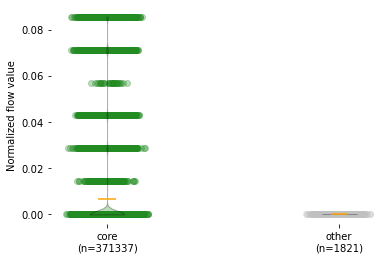


    Cut edges sourcing from cores: DescribeResult(nobs=70, minmax=(0.0, 283.4714285714286), mean=17.420612244897956, variance=3047.8794772890533, skewness=3.400982311249319, kurtosis=11.154562823901)
    Cut edges targeting cores: DescribeResult(nobs=70, minmax=(0.0, 444.2857142857143), mean=17.42061224489796, variance=5231.181003464741, skewness=4.973583255559928, kurtosis=24.497042823490705)
    Cut edges sourcing from others: DescribeResult(nobs=3, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=3, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.043
    Core targets vs Other targets Welch t test:  2.015 p= 0.048
    Kolmogorov-Smirnov Effect Size: 0.157


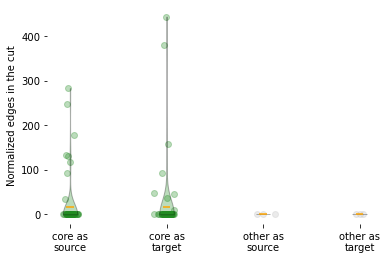

area:  SomMoCtx
population: 0
    population firing: 3.34±2.79 sp/frame
    cells firing rate: 0.05±0.23 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.6765188650349785
... find peaks
... find minima
... find population events
... signatures of population events
    number of events: 9030
    number of events per sec: 1.766137223190262
    events duration: 0.090±0.039
    events size: 17.000±6.693
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
... loaded surrogates
    cluster reproducibility threshold: 0.20754796714864582
    cluster size threshold: 2
    Total number of clusters: 174
    # clusters (after removing those below reproducibility threshold): 171
    event color assignment
    unique color assignments
    clustered similarity map
... finding cluster cores
    removing cores firing unspecifically
    gathering cores from all c

/tmp/ipykernel_9130/2282007953.py:178: RuntimeWarning: divide by zero encountered in power
  return a * (x**-b)


    Flow cores: DescribeResult(nobs=268016, minmax=(0.0, 0.03389830508474576), mean=0.0018364701727900886, variance=3.4729739750744214e-05, skewness=3.3455595123562496, kurtosis=11.281156755525133)
    Flow others: DescribeResult(nobs=2608, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Welch t test:  161.329 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.096


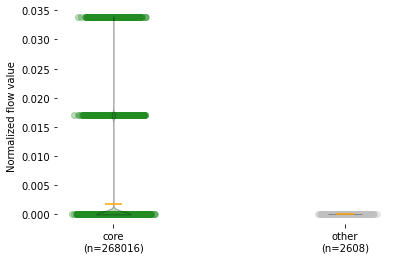


    Cut edges sourcing from cores: DescribeResult(nobs=59, minmax=(0.0, 172.94915254237287), mean=4.171215168055157, variance=520.1150748884611, skewness=7.065563852117207, kurtosis=49.631799514251)
    Cut edges targeting cores: DescribeResult(nobs=59, minmax=(0.0, 69.44067796610169), mean=4.171215168055157, variance=174.29889047851145, skewness=3.4932095252431083, kurtosis=11.856593340958833)
    Cut edges sourcing from others: DescribeResult(nobs=6, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=6, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.051
    Core targets vs Other targets Welch t test:  2.427 p= 0.018
    Kolmogorov-Smirnov Effect Size: 0.136


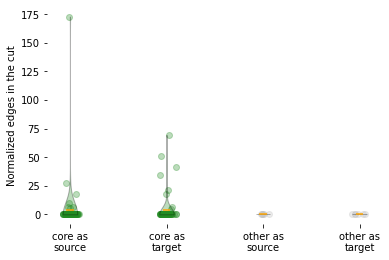

population: 1
    population firing: 1.64±1.58 sp/frame
    cells firing rate: 0.06±0.28 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 2.2897011667771343
... find peaks
... find minima
... find population events
... signatures of population events
    number of events: 8136
    number of events per sec: 1.5923090065858887
    events duration: 0.090±0.039
    events size: 6.000±2.804
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
... loaded surrogates
    cluster reproducibility threshold: 0.350415189240472
    cluster size threshold: 2
    Total number of clusters: 57
    # clusters (after removing those below reproducibility threshold): 57
    event color assignment
    unique color assignments
    clustered similarity map
... finding cluster cores
    removing cores firing unspecifically
    gathering cores from all clusters
    # cores:

/tmp/ipykernel_9130/2282007953.py:178: RuntimeWarning: divide by zero encountered in power
  return a * (x**-b)


    Flow cores: DescribeResult(nobs=90864, minmax=(0.0, 0.19047619047619047), mean=0.02680824927259159, variance=0.0012384064177680379, skewness=1.585584382592375, kurtosis=3.2570320805806894)
    Flow others: DescribeResult(nobs=2226, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Welch t test:  229.632 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.454


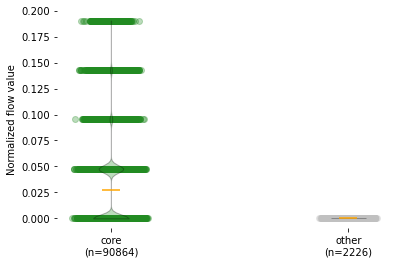


    Cut edges sourcing from cores: DescribeResult(nobs=21, minmax=(0.0, 459.3809523809524), mean=57.997732426303855, variance=13885.301922038658, skewness=2.524615229575417, kurtosis=5.4037688556700125)
    Cut edges targeting cores: DescribeResult(nobs=21, minmax=(0.0, 343.14285714285717), mean=57.99773242630387, variance=7991.347953784689, skewness=1.830343576648246, kurtosis=2.9295603018317378)
    Cut edges sourcing from others: DescribeResult(nobs=5, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=5, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.143
    Core targets vs Other targets Welch t test:  2.973 p= 0.008
    Kolmogorov-Smirnov Effect Size: 0.571


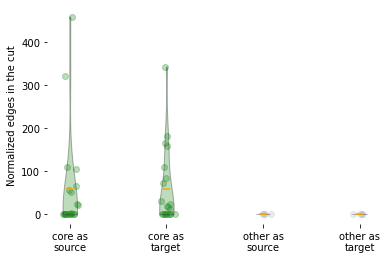

area:  V1
population: 0
    population firing: 4.36±4.39 sp/frame
    cells firing rate: 0.07±0.30 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 5.639604262147799
... find peaks
... find minima
... find population events
... signatures of population events
    number of events: 8608
    number of events per sec: 1.6862379048964173
    events duration: 0.100±0.042
    events size: 21.000±9.282
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
... loaded surrogates
    cluster reproducibility threshold: 0.1891990294759251
    cluster size threshold: 2
    Total number of clusters: 117
    # clusters (after removing those below reproducibility threshold): 117
    event color assignment
    unique color assignments
    clustered similarity map
... finding cluster cores
    removing cores firing unspecifically
    gathering cores from all clusters

/tmp/ipykernel_9130/2282007953.py:178: RuntimeWarning: divide by zero encountered in power
  return a * (x**-b)


    Flow cores: DescribeResult(nobs=333015, minmax=(0.0, 0.16363636363636364), mean=0.017391845576161597, variance=0.001548047337200557, skewness=2.4721513036370757, kurtosis=5.355315286075802)
    Flow others: DescribeResult(nobs=3731, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Welch t test:  255.085 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.226


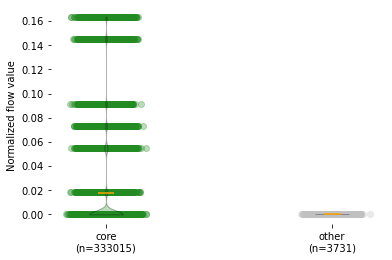


    Cut edges sourcing from cores: DescribeResult(nobs=55, minmax=(0.0, 975.6), mean=52.65223140495868, variance=24010.355286863127, skewness=4.316692250950576, kurtosis=21.41003126872525)
    Cut edges targeting cores: DescribeResult(nobs=55, minmax=(0.0, 773.6727272727272), mean=52.65223140495868, variance=18585.882804463356, skewness=3.5303241861013155, kurtosis=13.715495465977611)
    Cut edges sourcing from others: DescribeResult(nobs=6, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=6, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.073
    Core targets vs Other targets Welch t test:  2.864 p= 0.006
    Kolmogorov-Smirnov Effect Size: 0.291


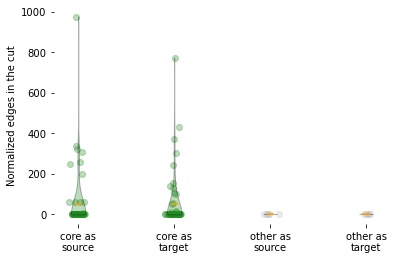

population: 1
    population firing: 4.49±4.18 sp/frame
    cells firing rate: 0.03±0.18 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 5.958191066649793
... find peaks
... find minima
... find population events
... signatures of population events
    number of events: 8037
    number of events per sec: 1.5737044693833515
    events duration: 0.100±0.045
    events size: 27.000±15.446
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 318
    # clusters (after removing those below reproducibility threshold): 318
    event color assignment
    unique color assignments
    clustered similarity map
... finding cluster cores
    removing cores firing unspecifically
    gathering cores from all clusters
    # cores: 140
    # 

/tmp/ipykernel_9130/2282007953.py:178: RuntimeWarning: divide by zero encountered in power
  return a * (x**-b)


    Flow cores: DescribeResult(nobs=427960, minmax=(0.0, 0.05714285714285714), mean=0.002621974016263202, variance=9.876452807543884e-05, skewness=4.0404540671086915, kurtosis=15.574025926980799)
    Flow others: DescribeResult(nobs=550, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Welch t test:  172.596 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.088


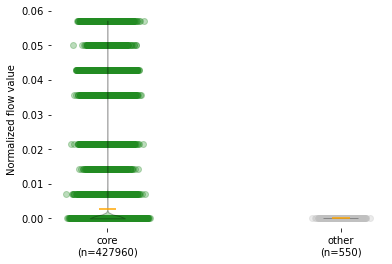


    Cut edges sourcing from cores: DescribeResult(nobs=140, minmax=(0.0, 150.62857142857143), mean=4.007499999999999, variance=354.27331179342247, skewness=5.987238100281942, kurtosis=37.99988069060924)
    Cut edges targeting cores: DescribeResult(nobs=140, minmax=(0.0, 134.6), mean=4.007499999999999, variance=296.23473228967845, skewness=5.54386795688666, kurtosis=33.84166890346316)
    Cut edges sourcing from others: DescribeResult(nobs=1, minmax=(0.0, 0.0), mean=0.0, variance=nan, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=1, minmax=(0.0, 0.0), mean=0.0, variance=nan, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.021
    Core targets vs Other targets Welch t test:  nan p= nan
    Kolmogorov-Smirnov Effect Size: 0.114


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


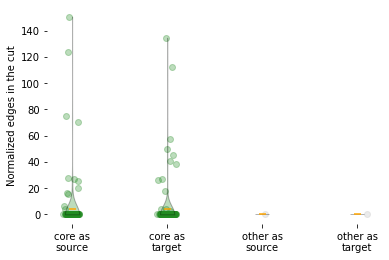

population: 2
    population firing: 3.42±3.43 sp/frame
    cells firing rate: 0.05±0.23 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.457858931076882
... find peaks
... find minima
... find population events
... signatures of population events
    number of events: 8706
    number of events per sec: 1.7065107324353472
    events duration: 0.100±0.042
    events size: 21.000±9.162
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
... loaded surrogates
    cluster reproducibility threshold: 0.18345279553233068
    cluster size threshold: 2
    Total number of clusters: 167
    # clusters (after removing those below reproducibility threshold): 165
    event color assignment
    unique color assignments
    clustered similarity map
... finding cluster cores
    removing cores firing unspecifically
    gathering cores from all clusters
    # co

/tmp/ipykernel_9130/2282007953.py:178: RuntimeWarning: divide by zero encountered in power
  return a * (x**-b)


    Flow cores: DescribeResult(nobs=334681, minmax=(0.0, 0.16923076923076924), mean=0.019092807778152927, variance=0.0013635698632959807, skewness=2.0244050315298767, kurtosis=3.6164557536359627)
    Flow others: DescribeResult(nobs=1205, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Welch t test:  299.121 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.259


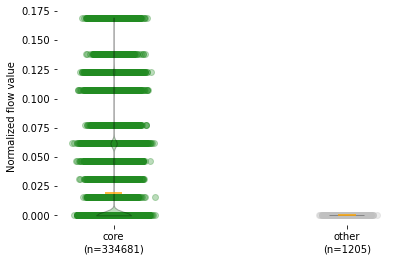


    Cut edges sourcing from cores: DescribeResult(nobs=65, minmax=(0.0, 483.04615384615386), mean=49.15384615384615, variance=10756.852699704143, skewness=2.21366665188415, kurtosis=4.524018094964825)
    Cut edges targeting cores: DescribeResult(nobs=65, minmax=(0.0, 753.2153846153847), mean=49.15384615384615, variance=18202.204955621302, skewness=3.696076438461031, kurtosis=14.364774748361896)
    Cut edges sourcing from others: DescribeResult(nobs=3, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=3, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.077
    Core targets vs Other targets Welch t test:  2.937 p= 0.005
    Kolmogorov-Smirnov Effect Size: 0.262


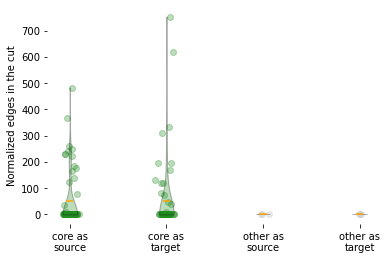

population: 3
    population firing: 3.66±3.35 sp/frame
    cells firing rate: 0.06±0.25 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.792838315565842
... find peaks
... find minima
... find population events
... signatures of population events
    number of events: 8179
    number of events per sec: 1.6040161001718742
    events duration: 0.100±0.045
    events size: 19.000±9.055
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
... loaded surrogates
    cluster reproducibility threshold: 0.19231125284303718
    cluster size threshold: 2
    Total number of clusters: 110
    # clusters (after removing those below reproducibility threshold): 110
    event color assignment
    unique color assignments
    clustered similarity map
... finding cluster cores
    removing cores firing unspecifically
    gathering cores from all clusters
    # co

/tmp/ipykernel_9130/2282007953.py:178: RuntimeWarning: divide by zero encountered in power
  return a * (x**-b)


    Flow cores: DescribeResult(nobs=293713, minmax=(0.0, 0.1), mean=0.005712833049042205, variance=0.00021606888645006535, skewness=2.911010324743757, kurtosis=8.13530277385999)
    Flow others: DescribeResult(nobs=2761, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Welch t test:  210.628 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.174


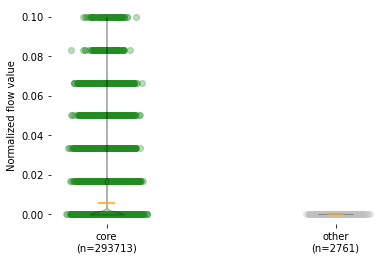


    Cut edges sourcing from cores: DescribeResult(nobs=60, minmax=(0.0, 259.15), mean=13.982777777777779, variance=2192.396694601381, skewness=4.186605774936151, kurtosis=17.220524293431986)
    Cut edges targeting cores: DescribeResult(nobs=60, minmax=(0.0, 195.76666666666668), mean=13.982777777777779, variance=1340.9586437539235, skewness=3.089052619462292, kurtosis=9.947587665437329)
    Cut edges sourcing from others: DescribeResult(nobs=4, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=4, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.067
    Core targets vs Other targets Welch t test:  2.958 p= 0.004
    Kolmogorov-Smirnov Effect Size: 0.250


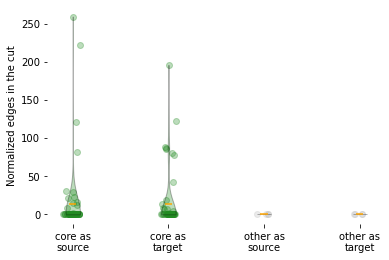



mouse: Waksman
area:  FrCtx
population: 0
    population firing: 1.43±1.43 sp/frame
    cells firing rate: 0.05±0.24 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 2.3165745600728145
... find peaks
... find minima
... find population events
... signatures of population events
    number of events: 13124
    number of events per sec: 2.15172091766536
    events duration: 0.090±0.037
    events size: 7.000±2.446
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
... entering creation of surrogate signatures
    cluster reproducibility threshold: 0.3179983683883768
    cluster size threshold: 2
    Total number of clusters: 111
    # clusters (after removing those below reproducibility threshold): 111
    event color assignment
    unique color assignments
    clustered similarity map
... finding cluster cores
    removing cores firing unspecifi

/tmp/ipykernel_9130/2282007953.py:168: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


... Local Clustering Coefficient


/tmp/ipykernel_9130/2282007953.py:178: RuntimeWarning: divide by zero encountered in power
  return a * (x**-b)


    Flow cores: DescribeResult(nobs=168197, minmax=(0.0, 0.03571428571428571), mean=0.004503647508576252, variance=0.00014056254869809575, skewness=2.252638148093832, kurtosis=3.074378626247606)
    Flow others: DescribeResult(nobs=903, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Welch t test:  155.790 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.126


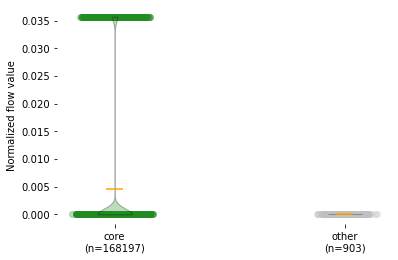


    Cut edges sourcing from cores: DescribeResult(nobs=28, minmax=(0.0, 172.17857142857142), mean=13.526785714285714, variance=1913.590667517007, skewness=3.1278223948564237, kurtosis=8.13799489780495)
    Cut edges targeting cores: DescribeResult(nobs=28, minmax=(0.0, 172.17857142857142), mean=13.526785714285714, variance=1913.590667517007, skewness=3.1278223948564237, kurtosis=8.13799489780495)
    Cut edges sourcing from others: DescribeResult(nobs=3, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=3, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  1.636 p= 0.113
    Kolmogorov-Smirnov Effect Size: 0.107


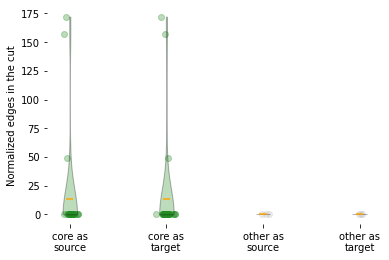

area:  FrMoCtx
population: 0
    population firing: 10.73±4.95 sp/frame
    cells firing rate: 0.02±0.16 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 16.286284244236832
... find peaks
... find minima
... find population events
... signatures of population events
    number of events: 6242
    number of events per sec: 1.0217723281071036
    events duration: 0.090±0.045
    events size: 68.500±29.556
... Similarity of events matrix
... clustering
    linkage
    surrogate events signatures for clustering threshold
... entering creation of surrogate signatures
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 1087
    # clusters (after removing those below reproducibility threshold): 1064
    event color assignment
    unique color assignments
    clustered similarity map
... finding cluster cores
    removing cores firing unspecifically
    gathering core

/tmp/ipykernel_9130/2282007953.py:178: RuntimeWarning: divide by zero encountered in power
  return a * (x**-b)


    Flow cores: DescribeResult(nobs=862952, minmax=(0.0, 0.004484304932735426), mean=2.4241536622211623e-05, variance=1.075013968891208e-07, skewness=13.490192423106073, kurtosis=180.25237752809213)


ValueError: The input must not be empty.

In [18]:
# start of spontaneous activity in each mouse (in seconds)
etstart = [3811, 3633, 3323]

for imouse,(mousename,areas) in enumerate(area_spiketrains.items()):
    print("\nmouse:",mousename)
    
    # if mousename!="Waksman":
    #     continue
    
    exp_path = local_path + '%s/'%mousename
    exp_tstart = etstart[imouse]

    # reading behavior data to make statistics about event dependence on it
    # we will use the field 'stimulus' to store the avg motSVD of the frames 
    # The behavioral file is the processed version of a mouse face movie (time x pixels x pixels). 
    faces = sio.loadmat('stringer/7739750/faces/%s_face_proc.mat'%mousename, squeeze_me=True)
    video_timestamps = faces['times'] # same temporal resolution of ephy
    motSVD = faces['motionSVD']
    exp_istart = (np.abs(video_timestamps - exp_tstart)).argmin()    
    motSVD_1c = motSVD[:,0] # only first component
    motSVD_1c[motSVD_1c < -4000] = np.mean(motSVD_1c) # corrections
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(video_timestamps[exp_istart:], motSVD_1c[exp_istart:], linewidth=0.5, color='k')
    fig.savefig(exp_path+"/motSVD_%s.png"%mousename, transparent=True, dpi=900)
    plt.close()
    fig.clear()
    fig.clf()

    for area,probe_populations in areas.items():
        if len(probe_populations)>0:
            print("area: ",area)
            
            # if area!="RSP":
            #     continue
                        
            for ipop,spiketrains in enumerate(probe_populations): 
                print("population:",ipop)

                # rounding to ms
                spiketrains = [np.round(sp, 3) for sp in spiketrains]
                start_time = min([min(st) if len(st) else 0 for st in spiketrains])
                stop_time = max([max(st) if len(st) else 0 for st in spiketrains])
                time = np.arange(start_time,stop_time,frame_duration)

                fig = plt.figure(figsize=[12.8,4.8])
                for row,train in enumerate(spiketrains):
                    plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
                plt.ylabel("cell IDs")
                plt.xlabel("time (s)")
                # plt.show()
                fig.savefig(exp_path+'%s_%s_rasterplot.png'%(area,ipop), transparent=False, dpi=800)
                plt.tight_layout()
                plt.close()
                
                ophys_cell_ids = list(range(len(spiketrains)))
                ophys_cell_indexes = ophys_cell_ids # here is an alias

                scan_spiketrains = spiketrains
                scan_id = '_%s_%s'%(area,ipop)
                
                # ---- start ---- comment out for all mice
                core_reproducibility_perc = 60 # threshold for detecting cores
                %run "dynamical_analysis.ipynb"
                
                # # Match smooth motion energy curve with the cluster it belongs to
                # # Count the number of events belonging to a pattern before and after the change.
                # ccolors,ccounts = np.unique(cluster_color_array, return_counts=True)
                # cluster_events_counts = dict(zip(ccolors,ccounts))
                # Npre_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # Npost_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # for sni in smoothed_beh_indices:
                #     snitime = exp_tstart + sni * frame_duration
                #     snitime_pre = snitime - 0.15 # s
                #     snitime_post = snitime + 0.15 # s
                #     for ievent,(event,ecolor) in enumerate(zip(events,cluster_color_array)):
                #         event_start_time = exp_tstart + event['start'] * frame_duration
                #         if snitime_pre < event_start_time and event_start_time < snitime:
                #             Npre_beh_cluster[ecolor] += 1
                #         if snitime < event_start_time and event_start_time < snitime_post:
                #             Npost_beh_cluster[ecolor] += 1
                # # detail
                # fig = plt.figure()
                # plt.scatter(range(len(Npre_beh_cluster.keys())), Npre_beh_cluster.values(), marker='<', c=list(Npre_beh_cluster.keys()), edgecolors=list(Npre_beh_cluster.keys()), s=1)
                # plt.scatter(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), marker='>', c=list(Npost_beh_cluster.keys()), edgecolors='none', s=1)
                # plt.vlines(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), Npre_beh_cluster.values(), colors=list(Npost_beh_cluster.keys()), linewidths=0.6)
                # plt.ylabel('occurrence')
                # plt.xlabel('Patterns')
                # fig.savefig(exp_path+"/results/Pattern_behavior_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                # # summary
                # Nsame = 0
                # Npost = 0
                # Npre = 0
                # for pre,post in zip(Npre_beh_cluster.values(),Npost_beh_cluster.values()):
                #     if pre==post: Nsame +=1
                #     if pre>post: Npre +=1
                #     if pre<post: Npost +=1
                # fig = plt.figure()
                # plt.bar([0,1,2], [Npre,Nsame,Npost], width=0.8, color='C0')
                # plt.ylabel('occurrences')
                # plt.xlabel('pattern timing relative to movement')
                # plt.xticks(range(3),['before','same','after'])
                # fig.savefig(exp_path+"/results/Pattern_behavior_summary_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                
                # # dimensional reduction, trajectories, and manifold checking
                # %run "attractor_analysis.ipynb"
                
                # ---- end ---- comment out for all mice
                
                # structural analysis
                # make binary spiketrains
                binary_spiketrains = np.zeros( (len(spiketrains),len(time)+2) )
                print(binary_spiketrains.shape)
                for row,train in enumerate(spiketrains):
                    # iterate over spiketrains assigning 1 to the binary_spiketrains at the corresponding position
                    tidxs = np.trunc(train/frame_duration).astype(int) - int(exp_tstart/frame_duration)
                    tidxs[tidxs>len(time)] = len(time) 
                    binary_spiketrains[row][tidxs] = 1
                # matrix
                print("... starting functional adjacency matrix")
                functional_adjacency_matrix = []
                for irow,bsti in enumerate(binary_spiketrains):
                    row_xcorr = []
                    for jrow,bstj in enumerate(binary_spiketrains):
                        if irow==jrow:
                            row_xcorr.append(0.0) # no self connections
                            continue
                        row_xcorr.append(crosscorrelation(bsti, bstj, maxlag=1, mode='corr')[2])
                    functional_adjacency_matrix.append(row_xcorr)
                functional_adjacency_matrix = np.array(functional_adjacency_matrix)
                print("    adjacency matrix:",functional_adjacency_matrix.shape)
                np.save(exp_path+"/results/functional_adjacency_matrix_%s%s.npy"%(area,ipop), functional_adjacency_matrix)
                # plot
                fig = plt.figure()
                plt.pcolormesh(functional_adjacency_matrix)
                cbar = plt.colorbar()
                fig.savefig(exp_path+'/results/adjacency_matrix_%s%s.png'%(area,ipop), transparent=True)
                plt.close()
                fig.clear()
                fig.clf()
                
                # creating graph from functional_adjacency_matrix as in Sadovsky and MacLean 2013
                functional_adjacency_matrix[ functional_adjacency_matrix <= functional_adjacency_matrix.max()*0.4 ] = 0.0
                functional_adjacency_matrix[ functional_adjacency_matrix >= functional_adjacency_matrix.max()*0.4 ] = 1.0
                
                dgraph = ig.Graph.Weighted_Adjacency(functional_adjacency_matrix, mode='directed')
                ig.plot(dgraph, exp_path+'/results/ring_%s%s.png'%(area,ipop), layout=dgraph.layout("circle"), edge_curved=0.2, edge_color='#000', edge_width=0.5, edge_arrow_size=0.1, vertex_size=5, vertex_color='#000', margin=50)
                print('    preparing vertex labels for cores and others')
                dgraph.vs["ophys_cell_id"] = ophys_cell_ids
                is_id_core = np.array( [0] * len(ophys_cell_ids) )
                is_id_core[core_indexes] = 1
                dgraph.vs["is_core"] = is_id_core.tolist()

                degrees = np.array(dgraph.degree())
                print("... Degree distributions")
                # https://igraph.org/python/api/latest/igraph._igraph.GraphBase.html#degree
                degdist = dgraph.degree_distribution(bin_width=5)
                degree_counts = [bi[2] for bi in degdist.bins()]
                fig = plt.figure()
                plt.plot(range(len(degree_counts)), degree_counts, linewidth=3.0)
                plt.ylabel('Number of vertices')
                plt.xlabel('Degree')
                plt.xscale('log')
                plt.yscale('log')
                plt.savefig(exp_path+'/results/degree_distribution_%s%s.png'%(area,ipop), transparent=True, dpi=300)
                plt.close()
                # Clustering Coefficient of only excitatory cells
                print('... Local Clustering Coefficient')
                # undirected only
                local_clustering_coefficients = np.array(dgraph.transitivity_local_undirected(vertices=None, mode="zero"))
                # fitting
                def powerlaw(x, a, b):
                    return a * (x**-b)
                paramsfit = [2, 1.05] # 334 EM-only all proofread
                # paramsfit = [1, 0.5] # 112 Ca/EM
                pfit = powerlaw(degrees, *paramsfit)
                # Coefficient of Determination
                # In the best case, the modeled values exactly match the observed values, which results in ss_res=0 and r2=1.
                # A baseline model, which always predicts np.mean(LCC), will have r2=0.
                # Models that have worse predictions than this baseline will have a negative r2.
                # residual sum of squares
                ss_res = np.sum((local_clustering_coefficients - pfit) ** 2)
                # total sum of squares
                ss_tot = np.sum((local_clustering_coefficients - np.mean(local_clustering_coefficients)) ** 2)
                # r-squared goodeness-of-fit
                r2 = 1 - (ss_res / ss_tot)
                # covariance matrix and eigenvalues/vectors
                Cov = np.cov(degrees,local_clustering_coefficients)
                # print("    Covariance matrix degrees,local_clustering_coefficients:")
                # print(Cov)
                w, v = np.linalg.eig(Cov)
                # plot
                fig = plt.figure()
                summer = mpcm.summer
                # for deg,ccoef in zip(degrees,local_clustering_coefficients):
                #     plt.scatter( deg, ccoef, marker='o', facecolor='#AAD400', s=10, edgecolors='none', alpha=0.25) # 22um
                plt.scatter( degrees,local_clustering_coefficients, marker='o', facecolor='#111111', s=50, edgecolors='none', alpha=0.5) 
                plt.plot(degrees,pfit,c='k')
                plt.yscale('log')
                plt.xscale('log')
                # plt.xlim([10,200])
                # plt.ylim([0.01,1])
                ax = plt.gca()
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                plt.ylabel('LCC')
                plt.xlabel('degree')
                # ax.set_xticklabels([])
                # ax.set_yticklabels([])
                plt.tick_params(axis='both', bottom='on', top='on', left='off', right='off')
                plt.title("eigv: {:.2f}, {:.4f} - fit x^: {:.2f} - GoF R2={:.2f}".format(w[0], w[1], paramsfit[1], r2))
                plt.tight_layout()
                fig.savefig(exp_path+"/results/hierarchical_modularity_%s%s.svg"%(area,ipop), transparent=True, dpi=900)
                plt.close()
                fig.clf()
                
                #--------------------------------------------------------------------
                # each edge has a capacity and each edge receives a flow. 
                # The amount of flow on an edge cannot exceed the capacity of the edge.
                # therefore, edges with high capacity will be more important for the flow.
                # here we test the hypothesis that edges towards cores have higher capacity
                # or that the sum of edges towards cores have a higher total capacity
                cell_total_capacity = {cid:list() for cid in ophys_cell_ids}
                edges_sourcing = {cid:0 for cid in ophys_cell_ids}
                edges_targeting = {cid:0 for cid in ophys_cell_ids}

                for cluster_k,events_cellids in scan_clustered_spectrums.items(): # we consider only the scan 0 because it's the largest (for now)
                    cluster_k = cluster_k.split(',')[0]

                    if cluster_k == 'gray':
                        continue

                    for vnt in events_cellids:
                        for posi,vidj in enumerate(vnt[1:]):
                            vidi = vnt[posi] # enumerate will go from 0
                            # print(vidi, vidj)

                            # check beginning and end are not the same
                            if dgraph.vs.find(ophys_cell_id=vidi).index == dgraph.vs.find(ophys_cell_id=vidj).index:
                                continue
                            # # check there is a path between the two
                            # if len(spinesgraph.get_all_shortest_paths(spinesgraph.vs.find(name=vidi).index, to=spinesgraph.vs.find(name=vidj).index, weights=None, mode='out'))>0:
                            #     continue

                            # Take the maximum flow between the previous and next vertices
                            mfres = dgraph.maxflow(dgraph.vs.find(ophys_cell_id=vidi).index, dgraph.vs.find(ophys_cell_id=vidj).index)
                            # print(mfres)
                            # returns a tuple containing the following:
                            # graph - the graph on which this flow is defined
                            # value - the value (capacity) of the maximum flow between the given vertices
                            # flow - the flow values on each edge. For directed graphs, this is simply a list where element i corresponds to the flow on edge i.
                            # cut - edge IDs in the minimal cut corresponding to the flow.
                            # partition - vertex IDs in the parts created after removing edges in the cut
                            # es - an edge selector restricted to the edges in the cut.

                            # we get a flow value for each edge contributing to the flow.
                            # source
                            mfres_value = mfres.value
                            if vidi in np.array(ophys_cell_ids)[core_indexes]:
                                mfres_value /= len(core_indexes)
                            else:
                                mfres_value /= len(other_indexes)
                            cell_total_capacity[vidi].append(mfres_value)
                            # target
                            mfres_value = mfres.value
                            if vidj in np.array(ophys_cell_ids)[core_indexes]:
                                mfres_value /= len(core_indexes)
                            else:
                                mfres_value /= len(other_indexes)
                            cell_total_capacity[vidj].append(mfres_value)

                            # Iterate over the edges identified by the flow.
                            # count the edges sourcing from cores, and those targeting cores. Which is more?
                            for edge in mfres.es:
                                sourceid = int(dgraph.vs[edge.source]['ophys_cell_id'])
                                targetid = int(dgraph.vs[edge.target]['ophys_cell_id'])
                                if sourceid in cell_total_capacity.keys():
                                    edges_sourcing[sourceid] +=1 # just count
                                if targetid in cell_total_capacity.keys():
                                    edges_targeting[targetid] +=1 # just count

                # Flow
                # print(cell_total_capacity)
                flowvalue_cores = []
                for cid in np.array(ophys_cell_ids)[core_indexes]:
                    flowvalue_cores.extend(cell_total_capacity[cid])
                flowvalue_others = []
                for cid in np.array(ophys_cell_ids)[other_indexes]:
                    flowvalue_others.extend(cell_total_capacity[cid])

                # description
                print("    Flow cores: "+str(stats.describe(flowvalue_cores)) )
                print("    Flow others: "+str(stats.describe(flowvalue_others)) )
                # significativity
                print("    Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowvalue_cores, flowvalue_others, equal_var=False))
                d,_ = stats.ks_2samp(flowvalue_cores, flowvalue_others) # non-parametric measure of effect size [0,1]
                print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

                fig, ax = plt.subplots()
                xs = np.random.normal(1, 0.04, len(flowvalue_cores))
                plt.scatter(xs, flowvalue_cores, alpha=0.3, c='forestgreen')
                xs = np.random.normal(2, 0.04, len(flowvalue_others))
                plt.scatter(xs, flowvalue_others, alpha=0.3, c='silver')
                vp = ax.violinplot([flowvalue_cores,flowvalue_others], widths=0.15, showextrema=False, showmeans=True)
                for pc in vp['bodies']:
                    pc.set_edgecolor('black')
                for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
                    pc.set_facecolor(cb)
                vp['cmeans'].set_color('orange')
                # vp['cmedians'].set_linewidth(2.)
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['right'].set_visible(False)
                plt.ylabel('Normalized flow value')
                plt.xticks([1, 2], ["core\n(n={:d})".format(len(flowvalue_cores)), "other\n(n={:d})".format(len(flowvalue_others))])
                fig.savefig(exp_path+"/results/global_cores_others_flowvalue_%s%s.svg"%(area,ipop), transparent=True)
                plt.show()
                # fig.clf()
                # plt.close()

                print()
                # Cuts
                # print(edges_sourcing)
                # print(edges_targeting)
                flowcuts_core_sources = []
                flowcuts_core_targets = []
                for cid in np.array(ophys_cell_ids)[core_indexes]:
                    flowcuts_core_sources.append(edges_sourcing[cid]/len(core_indexes))
                    flowcuts_core_targets.append(edges_targeting[cid]/len(core_indexes))
                flowcuts_other_sources = []
                flowcuts_other_targets = []
                for cid in np.array(ophys_cell_ids)[other_indexes]:
                    flowcuts_other_sources.append(edges_sourcing[cid]/len(other_indexes))
                    flowcuts_other_targets.append(edges_targeting[cid]/len(other_indexes))

                # description
                print("    Cut edges sourcing from cores: "+str(stats.describe(flowcuts_core_sources)) )
                print("    Cut edges targeting cores: "+str(stats.describe(flowcuts_core_targets)) )
                print("    Cut edges sourcing from others: "+str(stats.describe(flowcuts_other_sources)) )
                print("    Cut edges targeting others: "+str(stats.describe(flowcuts_other_targets)) )
                # significativity
                print("    Core targets vs sources Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowcuts_core_targets, flowcuts_core_sources, equal_var=False))
                d,_ = stats.ks_2samp(flowcuts_core_targets, flowcuts_core_sources) # non-parametric measure of effect size [0,1]
                print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

                print("    Core targets vs Other targets Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowcuts_core_targets, flowcuts_other_targets, equal_var=False))
                d,_ = stats.ks_2samp(flowcuts_core_targets, flowcuts_other_targets) # non-parametric measure of effect size [0,1]
                print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

                fig, ax = plt.subplots()
                xs = np.random.normal(1, 0.04, len(flowcuts_core_sources))
                plt.scatter(xs, flowcuts_core_sources, alpha=0.3, c='forestgreen')
                xs = np.random.normal(2, 0.04, len(flowcuts_core_targets))
                plt.scatter(xs, flowcuts_core_targets, alpha=0.3, c='forestgreen')
                xs = np.random.normal(3, 0.04, len(flowcuts_other_sources))
                plt.scatter(xs, flowcuts_other_sources, alpha=0.3, c='silver')
                xs = np.random.normal(4, 0.04, len(flowcuts_other_targets))
                plt.scatter(xs, flowcuts_other_targets, alpha=0.3, c='silver')
                vp = ax.violinplot([flowcuts_core_sources,flowcuts_core_targets,flowcuts_other_sources,flowcuts_other_targets], widths=0.15, showextrema=False, showmeans=True)
                for pc in vp['bodies']:
                    pc.set_edgecolor('black')
                for pc in vp['bodies'][0:2]:
                    pc.set_facecolor('#228B224d')
                for pc in vp['bodies'][2:]:
                    pc.set_facecolor('#D3D3D34d')
                vp['cmeans'].set_color('orange')
                # vp['cmedians'].set_linewidth(2.)
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['right'].set_visible(False)
                plt.ylabel('Normalized edges in the cut')
                plt.xticks([1, 2, 3, 4], ["core as\nsource", "core as\ntarget", "other as\nsource", "other as\ntarget"])
                fig.savefig(exp_path+"/results/global_cores_others_cutvalue_%s%s.svg"%(area,ipop), transparent=True)
                plt.show()
                # fig.clf()
                # plt.close()
                #--------------------------------------------------------------------
                
    gc.collect()
    print()
    
    # 0/0 # using only 'Krebs' mouse to save execution time.
    